# LIBRARY

In [180]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# IMPORT

In [181]:
# Load data
train = pd.read_csv('src/train.csv')
test = pd.read_csv('src/test.csv')

# CLEANING

In [182]:
# Define numerical and categorical columns
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
object_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [183]:
# Drop unnecessary columns
drop_cols = ["id"]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [184]:
# Handle missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

train[numerical_cols] = num_imputer.fit_transform(train[numerical_cols])
test[numerical_cols] = num_imputer.transform(test[numerical_cols])

train[object_cols] = cat_imputer.fit_transform(train[object_cols])
test[object_cols] = cat_imputer.transform(test[object_cols])

In [185]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39550 entries, 0 to 39549
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39550 non-null  float64
 1   person_income               39550 non-null  float64
 2   person_home_ownership       39550 non-null  object 
 3   person_emp_length           39550 non-null  float64
 4   loan_intent                 39550 non-null  object 
 5   loan_grade                  39550 non-null  object 
 6   loan_amnt                   39550 non-null  float64
 7   loan_int_rate               39550 non-null  float64
 8   loan_percent_income         39550 non-null  float64
 9   cb_person_default_on_file   39550 non-null  object 
 10  cb_person_cred_hist_length  39550 non-null  float64
 11  loan_status                 39550 non-null  int64  
dtypes: float64(7), int64(1), object(4)
memory usage: 3.6+ MB


In [186]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  16950 non-null  float64
 1   person_income               16950 non-null  float64
 2   person_home_ownership       16950 non-null  object 
 3   person_emp_length           16950 non-null  float64
 4   loan_intent                 16950 non-null  object 
 5   loan_grade                  16950 non-null  object 
 6   loan_amnt                   16950 non-null  float64
 7   loan_int_rate               16950 non-null  float64
 8   loan_percent_income         16950 non-null  float64
 9   cb_person_default_on_file   16950 non-null  object 
 10  cb_person_cred_hist_length  16950 non-null  float64
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


# Preprocessing

In [187]:
# Feature Engineering: Age Group & Income Bin
age_bins = [18, 25, 35, 45, 55, 65, 100]
income_bins = 5  # Quantile-based

train['age_group'] = pd.cut(train['person_age'], bins=age_bins, labels=False)
test['age_group'] = pd.cut(test['person_age'], bins=age_bins, labels=False)

train['income_bin'] = pd.qcut(train['person_income'], q=income_bins, labels=False)
test['income_bin'] = pd.qcut(test['person_income'], q=income_bins, labels=False)

In [188]:
# One-Hot Encoding for categorical variables
train = pd.get_dummies(train, columns=object_cols, drop_first=True)
test = pd.get_dummies(test, columns=object_cols, drop_first=True)

In [189]:
# Scale numerical features
scaler = MinMaxScaler()
num_features = train.select_dtypes(include=['int64', 'float64']).columns.drop('loan_status', errors='ignore')

train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

In [190]:
train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,age_group,income_bin,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0.111111,0.095801,0.236930,0.530600,0.352058,0.348710,0.068966,1,0.2,0.00,...,False,False,False,False,False,False,True,False,False,True
1,0.244444,0.334324,0.339738,0.545699,0.438426,0.330598,0.068966,0,0.2,1.00,...,False,False,True,True,False,False,False,False,False,False
2,0.088889,0.059691,0.195978,0.274969,0.588007,0.436350,0.034483,0,0.0,0.00,...,False,True,False,False,False,True,False,False,False,True
3,0.022222,0.089218,0.136568,0.336279,0.274750,0.358097,0.068966,0,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
4,0.066667,0.164456,0.113233,0.174373,0.473544,0.335353,0.000000,1,0.0,0.50,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39545,0.200000,0.781914,0.553532,0.146946,0.641554,0.235864,0.172414,0,0.2,1.00,...,False,False,False,False,True,False,False,False,False,False
39546,0.000000,0.276868,0.242301,0.423050,0.320928,0.349580,0.000000,0,0.0,1.00,...,False,False,False,True,False,False,False,False,False,False
39547,0.177778,0.149785,0.234988,0.537664,0.382813,0.600352,0.172414,1,0.2,0.25,...,False,True,False,False,True,False,False,False,False,True
39548,0.044444,0.054826,0.196408,0.194764,0.661261,0.417522,0.034483,1,0.0,0.00,...,False,True,False,False,False,True,False,False,False,True


In [191]:
test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,age_group,income_bin,person_home_ownership_OTHER,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0.022222,0.078558,0.247858,0.550519,0.542674,0.682922,0.068966,0.0,0.00,False,...,True,False,False,False,True,False,False,False,False,True
1,0.222222,0.285087,0.393477,0.325003,0.307457,0.245059,0.275862,0.2,1.00,False,...,False,False,True,False,False,False,False,False,False,False
2,0.088889,0.064400,0.105315,0.231694,0.555079,0.065056,0.068966,0.0,0.00,False,...,True,False,False,False,True,False,False,False,False,False
3,0.088889,0.172073,0.348055,0.658706,0.169218,0.240795,0.068966,0.0,0.50,False,...,False,False,False,False,False,False,False,False,False,False
4,0.133333,0.318693,0.198650,0.164427,0.061280,0.115112,0.000000,0.2,1.00,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16945,0.044444,0.157554,0.196605,0.324810,0.461813,0.341016,0.068966,0.0,0.50,False,...,False,False,False,False,False,True,False,False,False,False
16946,0.200000,0.231280,0.470544,0.140518,0.633286,0.163253,0.206897,0.2,0.75,False,...,False,False,False,False,False,True,False,False,False,True
16947,0.244444,0.098136,0.448694,0.203574,0.342667,0.364637,0.137931,0.2,0.25,False,...,False,False,True,False,True,False,False,False,False,False
16948,0.022222,0.161607,0.001523,0.325502,0.366217,0.413378,0.068966,0.0,0.50,True,...,False,False,False,True,False,False,False,False,False,False


# Training

In [192]:
# Target & Features
X = train.drop(columns=['loan_status'])
y = train['loan_status']

# Handle class imbalance
class_counts = y.value_counts()
class_weights = {0: class_counts[1] / len(y), 1: class_counts[0] / len(y)}

# Train-Test Split for Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [193]:
# Hyperparameters tuning
best_params = {
    'subsample': 0.6,
    'num_leaves': 50,
    'n_estimators': 500,
    'min_child_samples': 10,
    'max_depth': 10,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6
}

In [194]:
clf = lgb.LGBMClassifier(**best_params, objective='binary', metric='auc', class_weight=class_weights, random_state=42)
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Info] Number of positive: 8042, number of negative: 23598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 31640, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499983 -> initscore=-0.000067
[LightGBM] [Info] Start training from score -0.000067


LGBMClassifier(class_weight={0: np.float64(0.25418457648546144),
                             1: np.float64(0.7458154235145386)},
               colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
               metric='auc', min_child_samples=10, n_estimators=500,
               num_leaves=50, objective='binary', random_state=42,
               subsample=0.6)

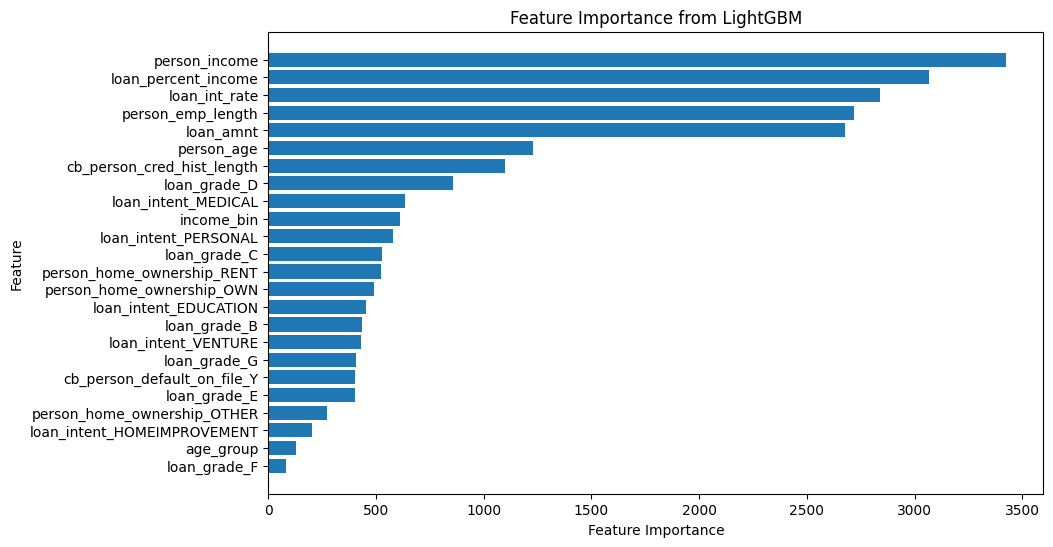

In [195]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from LightGBM")
plt.gca().invert_yaxis()
plt.show()

In [196]:
# select features
top_features = feature_importances[feature_importances['Importance'] > 5]['Feature']
X_reduced = X[top_features]

In [197]:
# Retrain Model
clf = lgb.LGBMClassifier(**best_params, objective='binary', metric='auc', class_weight=class_weights, random_state=42)
clf.fit(X_reduced, y)

[LightGBM] [Info] Number of positive: 10053, number of negative: 29497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 39550, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight={0: np.float64(0.25418457648546144),
                             1: np.float64(0.7458154235145386)},
               colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
               metric='auc', min_child_samples=10, n_estimators=500,
               num_leaves=50, objective='binary', random_state=42,
               subsample=0.6)

# Predict test case

In [206]:
# Apply on test data
test_reduced = test[top_features]
y_pred = clf.predict(test_reduced)

y_pred

array([1, 0, 1, ..., 0, 0, 0], shape=(16950,))

In [207]:
submit_df = pd.read_csv('src/sample_submission.csv')
submit_df

,id,loan_status
0,39550,1.0
1,39551,0.0
2,39552,1.0
3,39553,NaN
4,39554,NaN
...,...,...
16945,56495,NaN
16946,56496,NaN
16947,56497,NaN
16948,56498,NaN


In [208]:
submit_df['loan_status'] = y_pred

In [209]:
submit_df.to_csv('submission.csv', index=False)

submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           16950 non-null  int64
 1   loan_status  16950 non-null  int64
dtypes: int64(2)
memory usage: 265.0 KB


# Other

In [210]:
current_submit_df = pd.read_csv('submission.csv')
best_submit_df = pd.read_csv('submission0.68690.csv')

In [211]:
current_submit_df

,id,loan_status
0,39550,1
1,39551,0
2,39552,1
3,39553,0
4,39554,0
...,...,...
16945,56495,1
16946,56496,0
16947,56497,0
16948,56498,0


In [212]:
best_submit_df

,id,loan_status
0,39550,1
1,39551,0
2,39552,1
3,39553,0
4,39554,0
...,...,...
16945,56495,1
16946,56496,0
16947,56497,0
16948,56498,0


In [213]:
# Initialize a counter for differences
diff_count = 0

# Iterate over all rows
for i in range(len(current_submit_df)):
    # Get loan_status values for the current row in both dataframes
    current_loan_status = current_submit_df.iloc[i]['loan_status']
    best_loan_status = best_submit_df.iloc[i]['loan_status']
    
    # Compare the loan_status values
    if current_loan_status != best_loan_status:
        # Print the id and the differing loan_status
        id_value = current_submit_df.iloc[i]['id']
        print(f"Id: {id_value} has different loan_status values -> Current: {current_loan_status}, Previous: {best_loan_status}")
        diff_count += 1

# Print total number of differences
print(f"Total differences: {diff_count}")


Total differences: 0
